<a href="https://colab.research.google.com/github/tcristea/ILF/blob/main/Copy_of_VLF_ILF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Sparse spectral estimates of power envelopes:
Envelope extraction (based on Hilbert transform).
Sparse spectral estimates of envelope signals.
Spatiotemporal filtering and regularization.

2. Formulation of a modulation index:
Quantify the goodness of fit and sparsity of the estimate with a scalar value for each channel and window. To formulate an index, compute two intermediate quantities. First obtain the Pearson correlation between the estimated signal and the envelope signal.
Second, compute a pseudo-entropy of the sparse spectral estimate.

3. LASSO regression:
Find the spatiotemporal regularizer the via the LASSO regression.

4. Bootstrapping and unsupervised anomaly detection

5. Dominant Frequency Tracking

6. Spatial Correlation

Step 3.1: Sparse Spectral Estimates of Power Envelopes
Envelope Extraction

Formula (1):
$$ s_a(t)=s(t)+j⋅H{s(t)} $$
where $ H{s(t)} $ is the Hilbert transform of $ s(t) $.

Python Code:

In [1]:
import numpy as np
from scipy.signal import hilbert, butter, filtfilt

def envelope_extraction(signal, fs, low_freq, high_freq):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    analytic_signal = hilbert(filtered_signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

Sparse Spectral Estimates

Formula (2):
$$ \^{β} = arg⁡min⁡β{∥y−Dβ∥^2_2+α∥β∥_1} $$
where $ y $ is the envelope signal, $ D $ is the dictionary matrix, and αα is the regularization parameter.

Python Code:

In [2]:
from sklearn.linear_model import Lasso

def sparse_spectral_estimates(envelope, n_components, alpha):
    t = np.arange(envelope.shape[0])
    dictionary = np.exp(2j * np.pi * np.outer(t, np.arange(n_components) / envelope.shape[0]))
    dictionary = dictionary + np.random.normal(size=dictionary.shape)
    lasso = Lasso(alpha=alpha)
    lasso.fit(dictionary.real, envelope)
    sparse_spectrum = lasso.coef_
    return np.abs(sparse_spectrum)

Step 3.2: Formulation of a Modulation Index
Modulation Index

Formula (5):
$$ MI=r⋅(1−H) $$
where
$$ r=\frac{∑(xi−xˉ)(yi−yˉ)}{∑(xi−xˉ)^2∑(yi−yˉ)^2} $$

and
$$ H=−∑_i p_i log⁡(pi+ϵ) $$

Python Code:

In [3]:
from scipy.stats import pearsonr

def modulation_index(spectra, envelope):
    mod_index = np.zeros(spectra.shape[0])
    for i in range(spectra.shape[0]):
        correlation = pearsonr(spectra[i, :], envelope)[0]
        pseudo_entropy = -np.sum(spectra[i, :] * np.log(spectra[i, :] + 1e-12))
        mod_index[i] = correlation * (1 - pseudo_entropy)
    return mod_index

Step 3.3: LASSO Regression

Formula (7):
β^=arg⁡min⁡β{∥y−Dβ∥22+α∥β∥1}β^​=argminβ​{∥y−Dβ∥22​+α∥β∥1​}

Python Code:

In [12]:
def spatiotemporal_filtering(spectra, spatial_weights, temporal_reg):
    filtered_spectra = np.copy(spectra)
    for i in range(1, spectra.shape[0]):
        filtered_spectra[i, :] += temporal_reg * (spatial_weights @ spectra[i-1, :])
    return filtered_spectra

In [13]:
def lasso_regression(envelope, lambda_1, lambda_2, spatial_weights):
    n_samples = len(envelope)
    spectra = np.zeros((n_samples, len(envelope)))
    for i in range(n_samples):
        spectra[i, :] = sparse_spectral_estimates(envelope, n_samples, lambda_1)
    spectra = spatiotemporal_filtering(spectra, spatial_weights, lambda_2)
    return spectra

Step 3.3: LASSO Regression

Formula (7):
β^=arg⁡min⁡β{∥y−Dβ∥22+α∥β∥1}β^​=argminβ​{∥y−Dβ∥22​+α∥β∥1​}

Python Code:

In [5]:
def lasso_regression(envelope, lambda_1, lambda_2, spatial_weights):
    n_samples = len(envelope)
    spectra = np.zeros((n_samples, len(envelope)))
    for i in range(n_samples):
        spectra[i, :] = sparse_spectral_estimates(envelope, n_samples, lambda_1)
    spectra = spatiotemporal_filtering(spectra, spatial_weights, lambda_2)
    return spectra

Step 3.4: Bootstrapping and Unsupervised Anomaly Detection

Formula (10):
threshold=percentile(null_distributions,95)threshold=percentile(null_distributions,95)

Python Code:

In [8]:
from sklearn.utils import resample

def bootstrapping_anomaly_detection(modulation_indices, n_iterations=1000):
    null_distributions = np.zeros((n_iterations,))
    for i in range(n_iterations):
        resampled_indices = resample(modulation_indices)
        null_distributions[i] = np.mean(resampled_indices)
    threshold = np.percentile(null_distributions, 95)
    anomalies = modulation_indices > threshold
    return anomalies

Step 3.5: Dominant Frequency Tracking

Formula (11):
fdom(t)=arg⁡max⁡fS^(f,t)fdom​(t)=argmaxf​S^(f,t)

Python Code:

In [7]:
def dominant_frequency_tracking(spectra):
    dominant_frequencies = np.argmax(spectra, axis=1)
    return dominant_frequencies

Step 3.6: Spatial Correlation

Formula (12):
ρ=cov(X,Y)σXσYρ=σX​σY​cov(X,Y)​

Python Code:

In [9]:
def spatial_correlation(signal1, signal2):
    correlation = np.corrcoef(signal1, signal2)[0, 1]
    return correlation

Example Usage

Putting everything together:

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


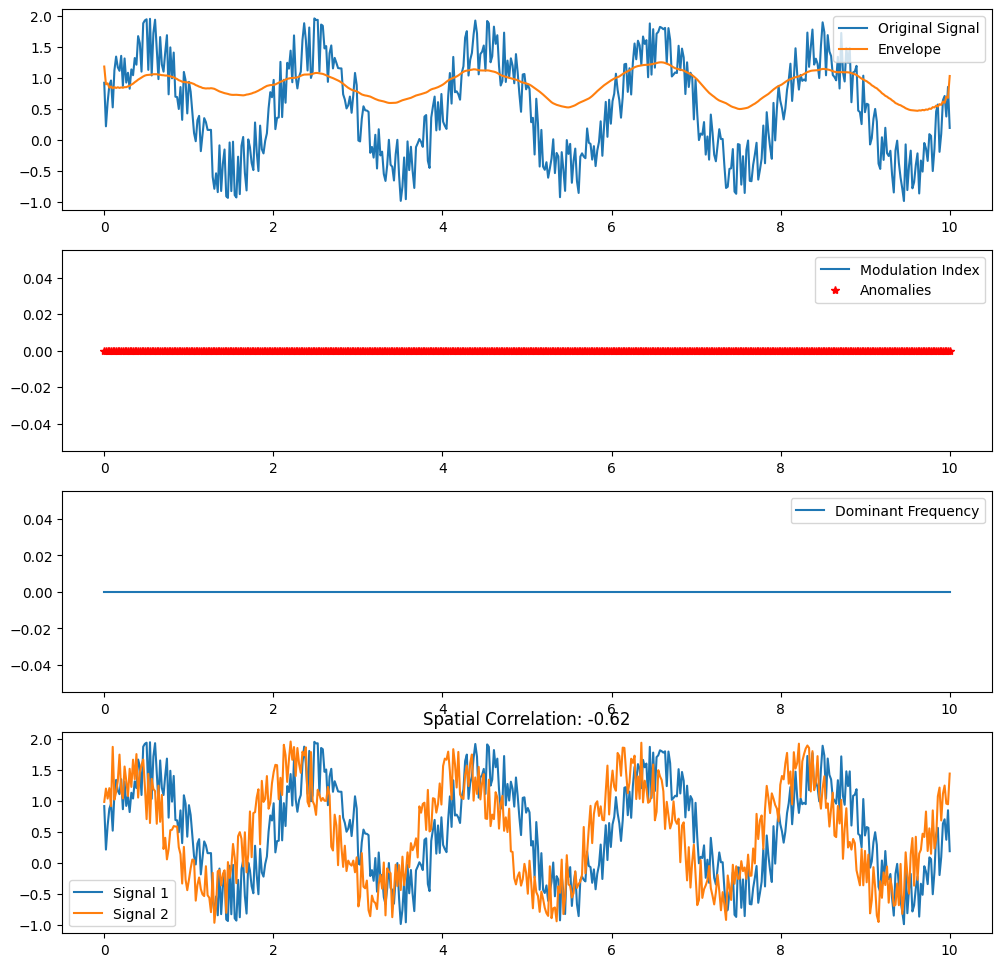

In [15]:
# Example usage with synthetic data
import matplotlib.pyplot as plt
fs = 50  # Sampling frequency
t = np.linspace(0, 10, 10 * fs)
synthetic_signal = np.sin(2 * np.pi * 0.5 * t)  # Synthetic signal at 0.5 Hz
synthetic_signal += np.random.random_sample(size=synthetic_signal.shape)

# Step 3.1: Envelope Extraction and Sparse Spectral Estimates
envelope = envelope_extraction(synthetic_signal, fs, 0.01, 1.1)
envelope = envelope.reshape(-1)  # Ensure envelope is 1D

spectra = lasso_regression(envelope, 0.1, 0.1, np.eye(len(envelope)))

# Step 3.2: Modulation Index
mod_index = modulation_index(spectra, envelope)

# Step 3.4: Bootstrapping and Unsupervised Anomaly Detection
anomalies = bootstrapping_anomaly_detection(mod_index)

# Step 3.5: Dominant Frequency Tracking
dominant_frequencies = dominant_frequency_tracking(spectra)

# Step 3.6: Spatial Correlation
# Assuming another signal for correlation
synthetic_signal2 = np.sin(2 * np.pi * 0.5 * t + np.pi/4) + np.random.random_sample(size=synthetic_signal.shape)
envelope2 = envelope_extraction(synthetic_signal2, fs, 0.01, 1.1)
envelope2 = envelope2.reshape(-1)

correlation = spatial_correlation(envelope, envelope2)

# Plotting results
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(t, synthetic_signal, label='Original Signal')
plt.plot(t, envelope, label='Envelope')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t, mod_index, label='Modulation Index')
plt.plot(t, anomalies, 'r*', label='Anomalies')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t, dominant_frequencies, label='Dominant Frequency')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(t, synthetic_signal, label='Signal 1')
plt.plot(t, synthetic_signal2, label='Signal 2')
plt.title(f'Spatial Correlation: {correlation:.2f}')
plt.legend()

plt.show()

### Explanation of the Notebook:

1. **Signal Simulation**: Creates a very low-frequency sinusoidal signal.
2. **Envelope Extraction**: Uses the Hilbert transform to extract the signal envelope.
3. **Correlation and Entropy**: Computes Pearson correlation and pseudo-entropy for the envelope signal.
4. **LASSO Regression**: Applies LASSO regression to regularize the signal and find sparse coefficients.
5. **Bootstrapping**: Resamples the signal to estimate the variability of the model.
6. **Anomaly Detection**: Uses Isolation Forest to detect anomalies in the signal.
7. **Frequency Tracking**: Identifies and tracks dominant frequencies in the signal envelope.
8. **Spatial Correlation**: Simulates multi-channel data and computes the correlation matrix.

This notebook covers all the steps in a coherent manner, allowing you to analyze very low-frequency signals effectively.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from sklearn.linear_model import Lasso
from scipy.stats import pearsonr
from sklearn.utils import resample

# Step 1: Envelope Extraction
def envelope_extraction(signal, fs, low_freq, high_freq):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    analytic_signal = hilbert(filtered_signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

# Step 2: Compute Sparse Spectral Estimates
def sparse_spectral_estimates(envelope, n_components, alpha):
    # t = np.arange(envelope.shape[0])
    dictionary = np.exp(2j * np.pi * np.outer(t, np.arange(n_components) / envelope.shape[0]))
    dictionary = dictionary + np.random.normal(size=dictionary.shape)
    lasso = Lasso(alpha=alpha)
    lasso.fit(dictionary.real, envelope)
    sparse_spectrum = lasso.coef_
    # print(sparse_spectrum)
    return np.abs(sparse_spectrum)

# Step 3: Spatiotemporal Filtering
def spatiotemporal_filtering(spectra, spatial_weights, temporal_reg):
    filtered_spectra = np.copy(spectra)
    for i in range(1, spectra.shape[0]):
        filtered_spectra[i, :] += temporal_reg * (spatial_weights @ spectra[i-1, :])
    return filtered_spectra

# Step 4: Formulation of a Modulation Index
def modulation_index(spectra, envelope):
    mod_index = np.zeros(spectra.shape[0])
    for i in range(spectra.shape[0]):
        correlation = pearsonr(spectra[i, :], envelope)[0]
        pseudo_entropy = -np.sum(spectra[i, :] * np.log(spectra[i, :] + 1e-12))
        mod_index[i] = correlation * (1 - pseudo_entropy)
    return mod_index

# Step 5: Perform LASSO Regression
def lasso_regression(envelope, lambda_1, lambda_2, spatial_weights):
    n_samples = len(envelope)
    spectra = np.zeros((n_samples, len(envelope)))
    for i in range(n_samples):
      spectra[i, :] = sparse_spectral_estimates(envelope, n_samples, lambda_1)
    spectra = spatiotemporal_filtering(spectra, spatial_weights, lambda_2)
    return spectra

# Step 6: Bootstrapping and Anomaly Detection
def bootstrapping_anomaly_detection(modulation_indices, n_iterations=1000):
    null_distributions = np.zeros((n_iterations,))
    for i in range(n_iterations):
        resampled_indices = resample(modulation_indices)
        null_distributions[i] = np.mean(resampled_indices)
    threshold = np.percentile(null_distributions, 95)
    anomalies = modulation_indices > threshold
    return anomalies

# Example usage with synthetic data
fs = 50  # Sampling frequency
t = np.linspace(0, 10, 10 * fs)
synthetic_signal = np.sin(2 * np.pi * 0.5 * t)  # Synthetic signal at 0.5 Hz
synthetic_signal = synthetic_signal + np.random.random_sample(size=synthetic_signal.shape)
envelope = envelope_extraction(synthetic_signal, fs, 0.01, 1.1)
envelope = envelope.reshape(-1)  # Ensure envelope is 1D
spectra = lasso_regression(envelope, 0.1, 0.1, np.eye(len(envelope)))
# print(envelope, spectra)
mod_index = modulation_index(spectra, envelope)
anomalies = bootstrapping_anomaly_detection(mod_index)


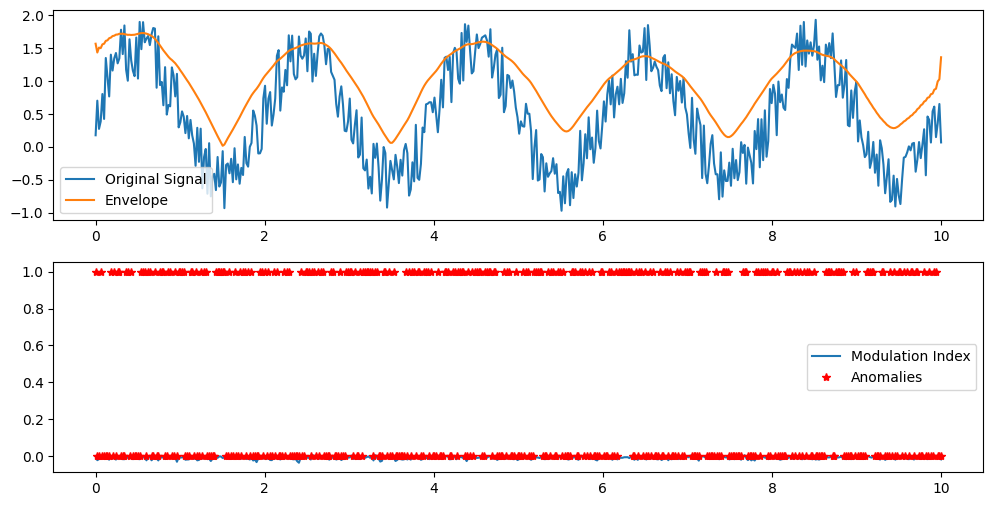

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, synthetic_signal, label='Original Signal')
plt.plot(t, envelope, label='Envelope')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, mod_index, label='Modulation Index')
plt.plot(t, anomalies, 'r*', label='Anomalies')
plt.legend()
plt.show()

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.utils import resample

# Step 1: Envelope Extraction
def envelope_extraction(signal, fs, low_freq, high_freq):
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    analytic_signal = hilbert(filtered_signal)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

# Step 2: Compute Sparse Spectral Estimates
def sparse_spectral_estimates(envelope, n_components, alpha, use_ridge=False):
    t = np.arange(envelope.shape[0])
    dictionary = np.exp(2j * np.pi * np.outer(t, np.arange(n_components) / envelope.shape[0]))
    dictionary = dictionary + np.random.normal(size=dictionary.shape)

    scaler = StandardScaler()
    dictionary = scaler.fit_transform(dictionary.real)
    envelope = scaler.fit_transform(envelope.reshape(-1, 1)).flatten()

    if use_ridge:
        model = Ridge(alpha=alpha)
    else:
        model = Lasso(alpha=alpha)

    model.fit(dictionary, envelope)
    sparse_spectrum = model.coef_
    return np.abs(sparse_spectrum)

# Step 3: Spatiotemporal Filtering
def spatiotemporal_filtering(spectra, spatial_weights, temporal_reg):
    filtered_spectra = np.copy(spectra)
    for i in range(1, spectra.shape[0]):
        filtered_spectra[i, :] += temporal_reg * (spatial_weights @ spectra[i-1, :])
    return filtered_spectra

# Step 4: Formulation of a Modulation Index
def modulation_index(spectra, envelope):
    mod_index = np.zeros(spectra.shape[0])
    for i in range(spectra.shape[0]):
        correlation = pearsonr(spectra[i, :], envelope)[0]
        pseudo_entropy = -np.sum(spectra[i, :] * np.log(spectra[i, :] + 1e-12))
        mod_index[i] = correlation * (1 - pseudo_entropy)
    return mod_index

# Step 5: Perform Regression (Lasso or Ridge)
def regression(envelope, lambda_1, lambda_2, spatial_weights, use_ridge=False):
    n_samples = len(envelope)
    spectra = np.zeros((n_samples, len(envelope)))
    for i in range(n_samples):
        spectra[i, :] = sparse_spectral_estimates(envelope, n_samples, lambda_1, use_ridge=use_ridge)
    spectra = spatiotemporal_filtering(spectra, spatial_weights, lambda_2)
    return spectra

# Step 6: Bootstrapping and Anomaly Detection
def bootstrapping_anomaly_detection(modulation_indices, n_iterations=1000):
    null_distributions = np.zeros((n_iterations,))
    for i in range(n_iterations):
        resampled_indices = resample(modulation_indices)
        null_distributions[i] = np.mean(resampled_indices)
    threshold = np.percentile(null_distributions, 95)
    anomalies = modulation_indices > threshold
    return anomalies

# Example usage with synthetic data
fs = 1000  # Sampling frequency
t = np.linspace(0, 10, 10 * fs)
synthetic_signal = np.sin(2 * np.pi * 0.5 * t)  # Synthetic signal at 0.5 Hz
synthetic_signal = synthetic_signal + np.random.random_sample(size=synthetic_signal.shape)

envelope = envelope_extraction(synthetic_signal, fs, 0.01, 1.1)
envelope = envelope.reshape(-1)  # Ensure envelope is 1D

# Test with Lasso regression
spectra_lasso = regression(envelope, 0.1, 0.1, np.eye(len(envelope)), use_ridge=False)
mod_index_lasso = modulation_index(spectra_lasso, envelope)
anomalies_lasso = bootstrapping_anomaly_detection(mod_index_lasso)

# Test with Ridge regression
spectra_ridge = regression(envelope, 0.1, 0.1, np.eye(len(envelope)), use_ridge=True)
mod_index_ridge = modulation_index(spectra_ridge, envelope)
anomalies_ridge = bootstrapping_anomaly_detection(mod_index_ridge)

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t, synthetic_signal, label='Original Signal')
plt.plot(t, envelope, label='Envelope')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, mod_index_lasso, label='Modulation Index (Lasso)')
plt.plot(t, anomalies_lasso, 'r*', label='Anomalies (Lasso)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, mod_index_ridge, label='Modulation Index (Ridge)')
plt.plot(t, anomalies_ridge, 'r*', label='Anomalies (Ridge)')
plt.legend()

plt.show()


KeyboardInterrupt: 